# San Francisco Bike Share Analysis
        : Strategic Optimization of Bike Share for Maximizing Usage During Commuting Hours

## Load packages

In [2]:
import pandas as pd          
import numpy as np           
import matplotlib.pyplot as plt  
import seaborn as sns
import  folium 
import mysql.connector
import warnings
from IPython.display import IFrame
warnings.filterwarnings("ignore")  

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

## Connect MySQL with Python

In [3]:
# Connect MySQL with Python
conn_local = mysql.connector.connect(
    host="localhost",         
    user="root",              
    password="1234",          
    database="bike"
)   

cursor = conn_local.cursor(buffered=True)

## Select city

In [4]:
# Only select 'San Francisco' out of 4
query = '''SELECT * FROM station'''
station = pd.read_sql_query(query, conn_local)

In [9]:
# color mappling by city
city_colors = {
    'San Francisco': 'red',
    'Palo Alto': 'blue',
    'Mountain View': 'green',
    'Redwood City': 'purple'
}

sf_center = [37.7749, -122.4194]
m = folium.Map(location=sf_center, zoom_start=9)

for _, row in station.iterrows():
    city = row['city']
    color = city_colors.get(city, 'gray')  
    
    folium.Marker(
        location=[row['lat'], row['longitude']],
        popup=f"<b>{row['name']}</b><br>Installed: {row['installation_date']}<br>City: {city}",
        icon=folium.Icon(color=color, icon='bicycle', prefix='fa')
    ).add_to(m)

#m.save('map.html')  
#IFrame('map.html', width=700, height=500) 

m

## Weekly usage

In [11]:
# High usage on weekdays (Monday to Friday), noticeable drop on weekends (Saturday and Sunday)
query = '''SELECT 
  DAYNAME(t.start_date) AS day_of_week,
  COUNT(*) AS total_rides,
  SUM(CASE 
        WHEN t.start_station_name != t.end_station_name THEN 1 
        ELSE 0 
      END) AS diff_station_rides,
  COUNT(*) - SUM(CASE 
        WHEN t.start_station_name != t.end_station_name THEN 1 
        ELSE 0 
      END) AS same_station_rides
FROM trip t
JOIN station s ON s.name = t.start_station_name
WHERE s.city = 'San Francisco' 
  AND duration > 120
GROUP BY day_of_week
ORDER BY FIELD(day_of_week, 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday');
'''
result3 = pd.read_sql_query(query, conn_local)
result3

,day_of_week,total_rides,diff_station_rides,same_station_rides
0,Monday,100173,98466.0,1707.0
1,Tuesday,105892,104350.0,1542.0
2,Wednesday,104054,102508.0,1546.0
3,Thursday,103149,101337.0,1812.0
4,Friday,94041,92088.0,1953.0
5,Saturday,35308,32710.0,2598.0
6,Sunday,29558,26999.0,2559.0


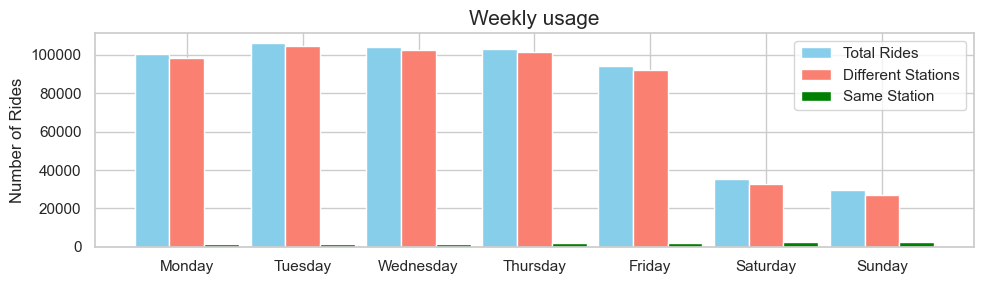

In [12]:
bar_width = 0.30
x = np.arange(len(result3['day_of_week']))

plt.figure(figsize=(10, 3))
plt.bar(x - bar_width, result3['total_rides'], width=bar_width, label='Total Rides', color='skyblue')
plt.bar(x, result3['diff_station_rides'], width=bar_width, label='Different Stations',  color='salmon')
plt.bar(x + bar_width, result3['same_station_rides'], width=bar_width, label='Same Station', color='green')

plt.xticks(x, result3['day_of_week'])
plt.ylabel('Number of Rides')
plt.title('Weekly usage', fontsize = 15)
plt.legend()
plt.tight_layout()
plt.show()

## Hourly usage on weekdays

In [ ]:
# Case 1 : start station ≠ end station
# Day of the week: Monday to Friday (weekday)

query = '''SELECT HOUR(start_date) AS hour, count(*) as trip_count 
FROM trip t
JOIN station s ON s.name = t.start_station_name
WHERE s.city = 'San Francisco'
	AND start_station_name != end_station_name
    AND DAYNAME(t.start_date) in ('Monday', 'Tuesday' ,'Wednesday', 'Thursday', 'Friday')
GROUP BY HOUR(start_date)                                 
ORDER BY trip_count DESC; '''
result4 = pd.read_sql_query(query, conn_local)
result4[:5]

,hour,trip_count
0,8,75688
1,17,66582
2,9,51917
3,18,45433
4,16,43728


In [ ]:
# Case 2 : start station = end station
# Day of the week: Monday to Friday (weekday)

query = '''SELECT HOUR(start_date) AS hour, count(*) as trip_count 
FROM trip t
JOIN station s ON s.name = t.start_station_name
WHERE s.city = 'San Francisco'
	AND start_station_name = end_station_name
    AND DAYNAME(t.start_date) in ('Monday', 'Tuesday' ,'Wednesday', 'Thursday', 'Friday')
GROUP BY HOUR(start_date)                                 
ORDER BY trip_count DESC; '''

result41 = pd.read_sql_query(query, conn_local)
result41[:5]

,hour,trip_count
0,12,1028
1,13,932
2,14,883
3,16,822
4,15,819


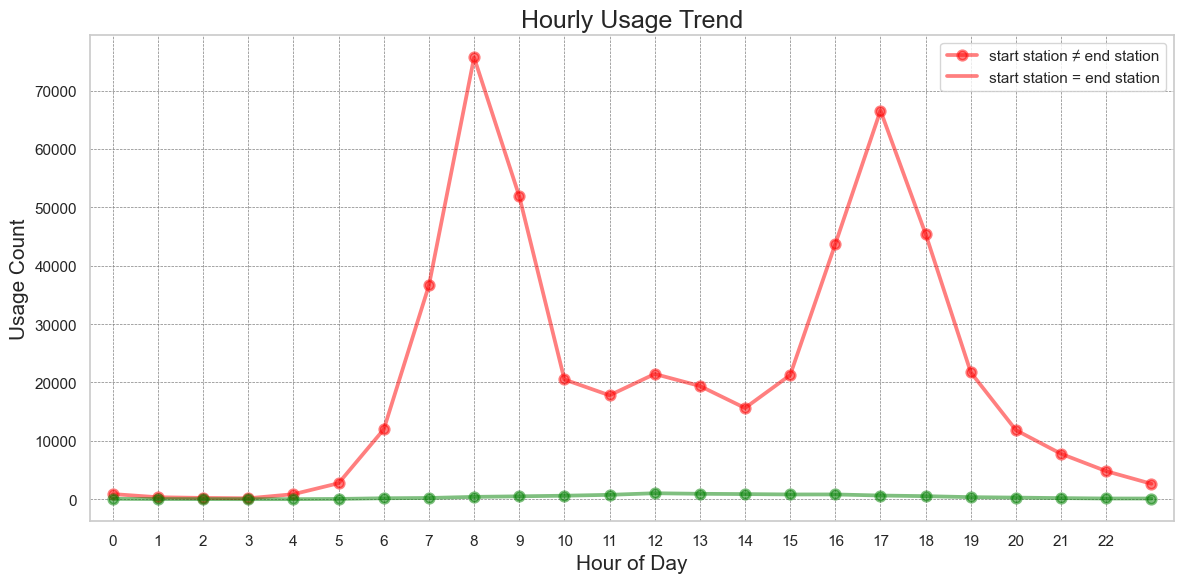

In [44]:
# Create a graph using the two tables above.
# In case 1, hours (8, 9, 16, 17, 18) show high usage.
# In case 2, hours (12, 13, 14, 15, 16) show slightly higher usage than other times.

sns.set_theme(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.pointplot(x='hour', y='trip_count', data=result4, color='red', alpha=0.5, label='Dataset 1')
sns.pointplot(x='hour', y='trip_count', data=result41, color='green', alpha=0.5, label='Dataset 2')

plt.title("Hourly Usage Trend", fontsize=18)
plt.xlabel("Hour of Day", fontsize=15)
plt.ylabel("Usage Count", fontsize=15)
plt.xticks(range(0, 23))

plt.legend(labels=['start station ≠ end station', 'start station = end station'])

plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, color='gray')
plt.tight_layout()
plt.show()


## Popular routes during weekday commute hours

### Check duration

In [16]:
query = '''SELECT * 
FROM trip t
JOIN station s ON s.name = t.start_station_name
WHERE s.city = 'San Francisco'
	AND start_station_name != end_station_name
    AND HOUR(t.start_date) in (8, 17, 9, 18, 16)
    AND DAYNAME(t.start_date) in ('Monday', 'Tuesday' ,'Wednesday', 'Thursday', 'Friday');'''

result5 = pd.read_sql_query(query, conn_local)
result5.head() 

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subcribtion_type,zip_code,date,id,name,lat,longitude,dock_count,city,installation_date
0,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,94703,2013-08-29,66,South Van Ness at Market,37.7748,-122.419,19,San Francisco,2013-08-23
1,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,94115,2013-08-29,66,South Van Ness at Market,37.7748,-122.419,19,San Francisco,2013-08-23
2,4075,1117,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,316,Subscriber,94122,2013-08-29,66,South Van Ness at Market,37.7748,-122.419,19,San Francisco,2013-08-23
3,4076,1118,2013-08-29 09:25:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,322,Subscriber,94597,2013-08-29,66,South Van Ness at Market,37.7748,-122.419,19,San Francisco,2013-08-23
4,4080,764,2013-08-29 09:36:00,South Van Ness at Market,66,2013-08-29 09:49:00,San Francisco Caltrain 2 (330 Townsend),69,315,Subscriber,94117,2013-08-29,66,South Van Ness at Market,37.7748,-122.419,19,San Francisco,2013-08-23


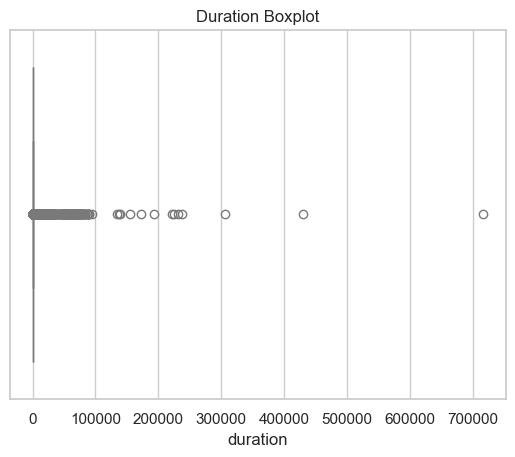

In [17]:
# Remove outliers over 100,000 sec
sns.boxplot(x='duration', data=result5, color='lightblue')
plt.title('Duration Boxplot')
plt.show()

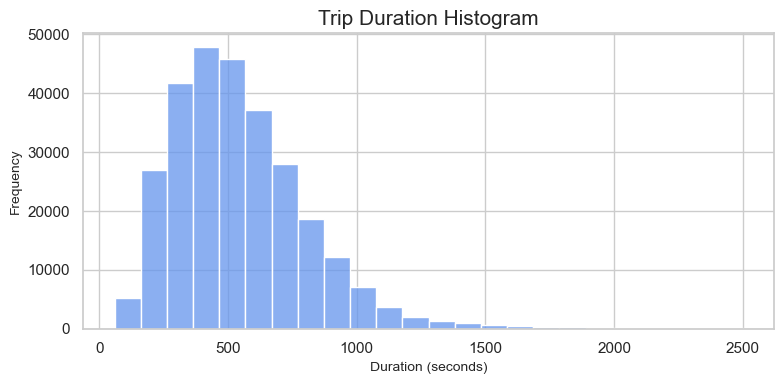

In [18]:
plt.figure(figsize=(8, 4))
sns.histplot(data=result5[result5['duration']<2500], x='duration', binwidth=100, color='cornflowerblue')

plt.xlabel('Duration (seconds)', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.title('Trip Duration Histogram' , fontsize=15)
plt.tight_layout()
plt.show()

In [19]:
# Check the percentage of trips longer than 1.5 hours
print(len(result5[result5['duration']>100000])) #13
print( len(result5[(result5['duration'] > 5400) & (result5['duration'] < 100000)])/len(result5)) # 0.4 %
print( len(result5[(result5['duration'] > 0) & (result5['duration'] < 180)])/len(result5)) # 2.73%

# Around 33 minutes (2000 seconds) is the meaningful data analysis range (Trip duration histogram)
# However, it's difficult to clearly define which durations correspond to commute times.
# Durations over 1.5 hours and under 3 minutes account for only 0.4% and 2.73%, respectively.
# Therefore, we include durations from 0 to 100,000 seconds in the analysis.

13
0.004040967291104931
0.027312703812979094


### Popular routes

In [20]:
# Popular commuting hours in the morning

query = '''
SELECT 
  HOUR(t.start_date) AS start_hour, 
  HOUR(t.end_date) AS end_hour, 
  s_start.id AS start_station_id, 
  s_end.id AS end_station_id,
  t.start_station_name, 
  t.end_station_name, 
  COUNT(*) AS number
FROM trip t
JOIN station s_start ON s_start.name = t.start_station_name
JOIN station s_end ON s_end.name = t.end_station_name
WHERE s_start.city = 'San Francisco' 
  AND t.start_station_name != t.end_station_name
  AND t.duration < 100000
  AND DAYNAME(t.start_date) IN ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday')
  AND HOUR(t.start_date) IN (8, 9)
GROUP BY 
  start_hour, 
  end_hour, 
  s_start.id, 
  s_end.id,
  t.start_station_name, 
  t.end_station_name
ORDER BY number DESC
LIMIT 5;'''

result51 = pd.read_sql_query(query, conn_local)
result51

,start_hour,end_hour,start_station_id,end_station_id,start_station_name,end_station_name,number
0,8,8,50,61,Harry Bridges Plaza (Ferry Building),2nd at Townsend,1341
1,9,9,69,65,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,1018
2,9,9,77,64,Market at Sansome,2nd at South Park,991
3,9,9,74,61,Steuart at Market,2nd at Townsend,910
4,8,8,69,65,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,886


In [21]:
# Popular commuting hours in the evening

query = '''
SELECT 
  HOUR(t.start_date) AS start_hour, 
  HOUR(t.end_date) AS end_hour, 
  s_start.id AS start_station_id, 
  s_end.id AS end_station_id,
  t.start_station_name, 
  t.end_station_name, 
  COUNT(*) AS number
FROM trip t
JOIN station s_start ON s_start.name = t.start_station_name
JOIN station s_end ON s_end.name = t.end_station_name
WHERE s_start.city = 'San Francisco' 
  AND t.start_station_name != t.end_station_name
  AND t.duration < 100000
  AND DAYNAME(t.start_date) IN ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday')
  AND HOUR(t.start_date) IN (18, 17)
GROUP BY 
  start_hour, 
  end_hour, 
  s_start.id, 
  s_end.id,
  t.start_station_name, 
  t.end_station_name
ORDER BY number DESC
LIMIT 5;'''

result52 = pd.read_sql_query(query, conn_local)
result52

,start_hour,end_hour,start_station_id,end_station_id,start_station_name,end_station_name,number
0,17,17,60,74,Embarcadero at Sansome,Steuart at Market,1064
1,17,17,61,50,2nd at Townsend,Harry Bridges Plaza (Ferry Building),992
2,17,17,64,77,2nd at South Park,Market at Sansome,911
3,17,17,65,70,Townsend at 7th,San Francisco Caltrain (Townsend at 4th),855
4,17,17,51,70,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),762


In [24]:
# Create a list of tuples containing (start_hour, start_station_name) & (end_hour, end_station_name)

start_station_list = list(zip(result51['start_hour'], result51['start_station_name'])) \
                          +list(zip(result52['start_hour'], result52['start_station_name']))
end_station_list = list(zip(result51['end_hour'], result51['end_station_name'])) \
                          + list(zip(result52['end_hour'], result52['end_station_name']))
start_station_list[:3], end_station_list[:3]

([(8, 'Harry Bridges Plaza (Ferry Building)'),
  (9, 'San Francisco Caltrain 2 (330 Townsend)'),
  (9, 'Market at Sansome')],
 [(8, '2nd at Townsend'), (9, 'Townsend at 7th'), (9, '2nd at South Park')])

## Avg_demand, Avg_available, and Demand_Supply_gap 
- by start stations during commuting hours (8, 9, 18, 17)

In [ ]:
# demand_supply_gap : avg_available minus avg_demand
# A smaller and negative value indicates the station may experience a supply shortage

query = '''SELECT 
    s.id AS station_id,
    s.name AS station_name,
    demand.hour,
    AVG(demand.trip_count) AS avg_demand,
    AVG(supply.avg_bike_available) AS avg_available,
    AVG(supply.avg_bike_available - demand.trip_count) AS demand_supply_gap
FROM
    (SELECT 
        start_station_name,
        HOUR(start_date) AS hour,
        DATE(start_date) AS date,
        COUNT(*) AS trip_count
    FROM trip
    WHERE DAYOFWEEK(start_date) BETWEEN 2 AND 6
    GROUP BY start_station_name, DATE(start_date), HOUR(start_date)) AS demand 
JOIN station s ON s.name = demand.start_station_name
LEFT JOIN
    (SELECT 
        station_id,
        HOUR(time) AS hour,
        DATE(time) AS date,
        AVG(bike_available) AS avg_bike_available
    FROM status
    WHERE DAYOFWEEK(time) BETWEEN 2 AND 6
    GROUP BY station_id, DATE(time), HOUR(time)) AS supply
ON s.id = supply.station_id AND demand.hour = supply.hour AND demand.date = supply.date
GROUP BY s.id, s.name, demand.hour
HAVING station_name in ( select name from station where city = 'San Francisco') and hour in (8, 9, 18, 17)
ORDER BY station_id;'''

result6 = pd.read_sql_query(query, conn_local)
result6

,station_id,station_name,hour,avg_demand,avg_available,demand_supply_gap
0,39,Powell Street BART,8,3.3340,10.368750,7.033333
1,39,Powell Street BART,9,3.4868,9.506122,6.024490
2,39,Powell Street BART,17,3.0233,9.936170,6.923404
3,39,Powell Street BART,18,2.8920,10.976139,8.084599
4,41,Clay at Battery,8,1.3103,5.593074,4.281385
...,...,...,...,...,...,...
135,77,Market at Sansome,18,4.0473,12.206612,8.157025
136,82,Broadway St at Battery St,8,1.8846,3.915789,2.028070
137,82,Broadway St at Battery St,9,2.1015,5.725309,3.620370
138,82,Broadway St at Battery St,17,5.6250,7.732984,2.130890


In [28]:
result61 = result6[result6.apply(lambda row: (row['hour'], row['station_name']) in start_station_list, axis=1)].sort_values('hour')
result61

,station_id,station_name,hour,avg_demand,avg_available,demand_supply_gap
32,50,Harry Bridges Plaza (Ferry Building),8,14.0432,11.960630,-2.064961
100,69,San Francisco Caltrain 2 (330 Townsend),8,16.1045,14.627723,-1.483168
101,69,San Francisco Caltrain 2 (330 Townsend),9,10.7390,8.724000,-2.012000
121,74,Steuart at Market,9,6.1285,9.509921,3.382937
133,77,Market at Sansome,9,4.6673,15.511202,10.839104
38,51,Embarcadero at Folsom,17,5.3327,6.544898,1.218367
66,60,Embarcadero at Sansome,17,6.1206,6.632094,0.504892
70,61,2nd at Townsend,17,7.0423,10.712551,3.674089
82,64,2nd at South Park,17,6.0940,7.291751,1.197183
86,65,Townsend at 7th,17,7.8990,6.452191,-1.440239


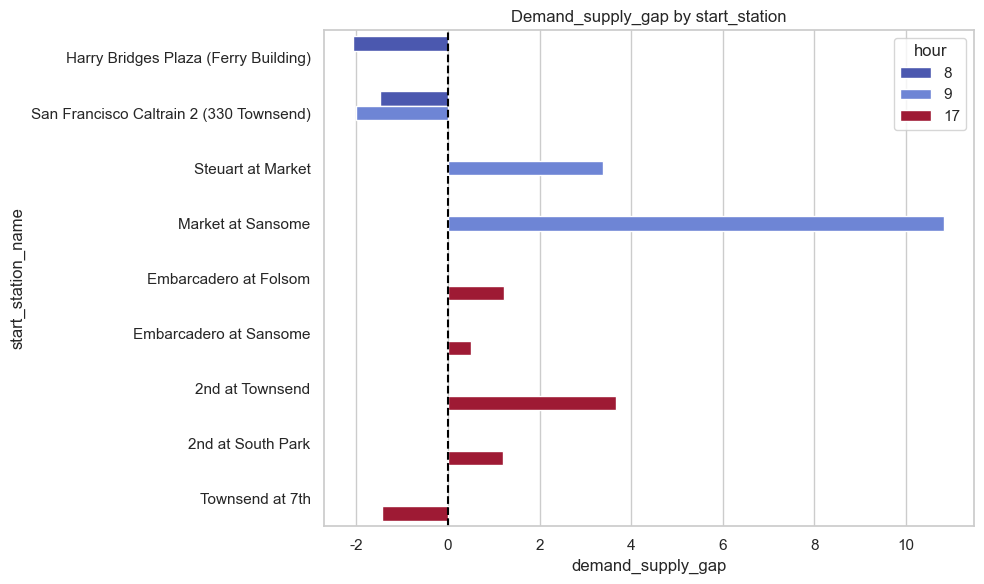

In [34]:
# 7 out of 10 popular start stations show values below 2
# with some especially having negative values

df_sorted = result61.sort_values('hour')

plt.figure(figsize=(10, 6))
sns.barplot(data=df_sorted, 
            x='demand_supply_gap', 
            y='station_name', 
            hue='hour', 
            palette='coolwarm')  

plt.axvline(0, color='black', linestyle='--')  
plt.title('Demand_supply_gap by start_station')
plt.xlabel('demand_supply_gap')
plt.ylabel('start_station_name')
plt.tight_layout()
plt.show()


## Identifying nearby bike rental stations within a 1 km radius of popular start stations

✅ Business Insights
- For example) Harry Bridges Plaza (Ferry Building) : This station has a supply shortage.(-2)
    - Steuart at Market: Located approximately 100 meters away, making it a walkable distance.
        - According to the table above, there is an average surplus of 4 bikes at 8 AM.
        - ✅ Suggest utilizing nearby station alerts to enable distributed operations.

    - Davis at Jackson: The table indicates an average rental demand of 2 rides around 8 AM, with a surplus of 4 to 5 bikes.
        - ✅ Monitor nearby inventory within 1 km and quickly reallocate bikes as needed.


In [ ]:
query = ''' SELECT id, name, lat, longitude,
    (6371 * acos(
        cos(radians(37.7954)) * cos(radians(lat)) * 
        cos(radians(longitude) - radians(-122.394)) + 
        sin(radians(37.7954)) * sin(radians(lat))
    )) AS distance_km
FROM station
HAVING distance_km < 1
ORDER BY distance_km;'''

result7 = pd.read_sql_query(query, conn_local)
result7 


,id,name,lat,longitude,distance_km
0,50,Harry Bridges Plaza (Ferry Building),37.7954,-122.394,0.017881
1,74,Steuart at Market,37.7941,-122.394,0.145173
2,42,Davis at Jackson,37.7973,-122.398,0.442375
3,56,Beale at Market,37.7923,-122.397,0.442880
4,51,Embarcadero at Folsom,37.7915,-122.391,0.509081
5,41,Clay at Battery,37.7950,-122.400,0.526518
6,55,Temporary Transbay Terminal (Howard at Beale),37.7898,-122.395,0.630058
7,75,Mechanics Plaza (Market at Battery),37.7913,-122.399,0.635929
8,49,Spear at Folsom,37.7903,-122.391,0.639111
9,48,Embarcadero at Vallejo,37.8000,-122.399,0.643572


In [ ]:
# Reference point coordinates
center_lat, center_lon = 37.7954, -122.394

# Created map
m = folium.Map(location=[center_lat, center_lon], zoom_start=15)

# Mark the reference point (blue)
folium.Marker(
    location=[center_lat, center_lon],
    popup='Center Point',
    icon=folium.Icon(color='blue')
).add_to(m)

# Showed each station
for idx, row in result7.iterrows():
    color = 'red' if row['distance_km'] < 1 else 'gray'  # Red if within 1 km, otherwise gray.
    folium.CircleMarker(
        location=[row['lat'], row['longitude']],
        radius=7,
        popup=f"{row['name']} ({row['distance_km']:.2f} km)",
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7
    ).add_to(m)

# Draw a 1 km radius circle from the reference point
folium.Circle(
    location=[center_lat, center_lon],
    radius=1000, 
    color='blue',
    fill=False
).add_to(m)

m

## Avg_arrivals, Remaining_bikes, and Capacity
: by end stations during commuting hours (8, 9, 10, 17, 18, 19)

In [ ]:
# Capacity: dock - avg_remaining_bikes - avg_arrival
# A smaller and more negative value indicates the station may experience a capacity shortage

query = '''SELECT 
    s.id AS station_id,
    s.name AS station_name,
    s.dock_count AS dock,
    demand.hour,
    AVG(demand.trip_count) AS avg_arrivalㄴ,
    AVG(supply.avg_bike_available) AS avg_remaining_bikes,  
    (s.dock_count - AVG(supply.avg_bike_available)- AVG(demand.trip_count)) AS capacity
FROM
    (SELECT 
        end_station_name,
        HOUR(end_date) AS hour,
        DATE(end_date) AS date,
        COUNT(*) AS trip_count
    FROM trip
    WHERE DAYOFWEEK(end_date) BETWEEN 2 AND 6
    GROUP BY end_station_name, DATE(end_date), HOUR(end_date)) AS demand
JOIN station s ON s.name = demand.end_station_name
LEFT JOIN
    (SELECT 
        station_id,
        HOUR(time) AS hour,
        DATE(time) AS date,
        AVG(bike_available) AS avg_bike_available
    FROM status
    WHERE DAYOFWEEK(time) BETWEEN 2 AND 6
    GROUP BY station_id, DATE(time), HOUR(time)) AS supply
ON s.id = supply.station_id AND demand.hour = supply.hour AND demand.date = supply.date
GROUP BY s.id, s.name, s.dock_count, demand.hour
HAVING station_name IN (
    SELECT name FROM station WHERE city = 'San Francisco'
) AND hour in (8, 9, 10, 17, 18, 19)
ORDER BY station_id;  '''

result8 = pd.read_sql_query(query, conn_local)
result8

,station_id,station_name,dock,hour,avg_arrival,avg_remaining_bikes,capacity
0,39,Powell Street BART,19,8,2.7426,10.362473,5.894973
1,39,Powell Street BART,19,9,3.2371,9.425620,6.337267
2,39,Powell Street BART,19,10,1.9435,9.282258,7.774194
3,39,Powell Street BART,19,17,4.3150,9.844581,4.840379
4,39,Powell Street BART,19,18,3.9069,10.995935,4.097182
...,...,...,...,...,...,...,...
205,82,Broadway St at Battery St,15,9,5.3368,5.833773,3.829385
206,82,Broadway St at Battery St,15,10,1.7468,7.939103,5.314103
207,82,Broadway St at Battery St,15,17,1.9580,7.946154,5.095831
208,82,Broadway St at Battery St,15,18,2.1525,4.135231,8.712286


In [39]:
result81 = result8[result8.apply(lambda row: (row['hour'], row['station_name']) in end_station_list, axis=1)].sort_values('hour')
result81 

,station_id,station_name,dock,hour,avg_arrival,avg_remaining_bikes,capacity
102,61,2nd at Townsend,27,8,8.3427,11.315895,7.341419
126,65,Townsend at 7th,15,8,8.8075,6.201195,-0.008735
103,61,2nd at Townsend,27,9,8.6812,12.646123,5.672689
121,64,2nd at South Park,15,9,6.0855,7.151639,1.762821
127,65,Townsend at 7th,15,9,8.1670,6.872255,-0.039253
51,50,Harry Bridges Plaza (Ferry Building),23,17,10.6894,11.818548,0.492073
159,70,San Francisco Caltrain (Townsend at 4th),19,17,25.8191,10.749511,-17.568577
183,74,Steuart at Market,23,17,8.7088,7.527273,6.763892
201,77,Market at Sansome,27,17,5.6004,12.729293,8.670305


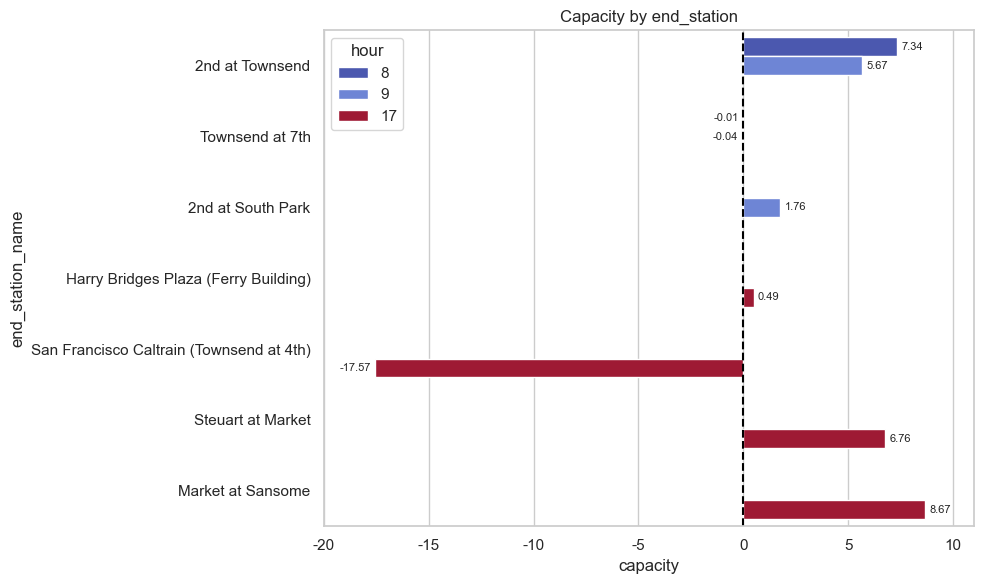

In [ ]:
# 5 out of 10 popular start stations show values below 2
# with some especially having negative values

df_sorted = result81.sort_values('hour')

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_sorted, 
            x='capacity', 
            y='station_name', 
            hue='hour', 
            palette='coolwarm')  

plt.axvline(0, color='black', linestyle='--')  
plt.title('Capacity by end_station')
plt.xlim(-20, 11)
plt.yticks()
plt.xlabel('capacity')
plt.ylabel('end_station_name')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3, fontsize=8)
plt.tight_layout()
plt.show()

## Identifying nearby bike rental stations within a 1 km radius of popular end stations

✅ Business Insights
- For example) San Francisco Caltrain (Townsend at 4th) : This station has a capacity shortage. (-18)
    - San Francisco Caltrain 2 (330 Townsend) : 
        - According to the table above, This station has a capacity shortage too.
    - 2nd at Townsend : 
        - This stations has around 11 capacity
        - ✅ Suggest users to divert here to alleviate congestion.
        - ✅ Coupon(Missed Dock Compensation) : To reduce user inconvenience when no docks are available at their destination, issue coupons as compensation for rerouting to nearby stations.

In [ ]:
query = ''' SELECT id, name, lat, longitude,
    (6371 * acos(
        cos(radians(37.7766)) * cos(radians(lat)) * 
        cos(radians(longitude) - radians(-122.395)) + 
        sin(radians(37.7766)) * sin(radians(lat))
    )) AS distance_km
FROM station
HAVING distance_km < 1
ORDER BY distance_km;'''

result9 = pd.read_sql_query(query, conn_local)
result9 

,id,name,lat,longitude,distance_km
0,70,San Francisco Caltrain (Townsend at 4th),37.7766,-122.395,0.023235
1,69,San Francisco Caltrain 2 (330 Townsend),37.7766,-122.395,0.041278
2,61,2nd at Townsend,37.7805,-122.390,0.601583
3,64,2nd at South Park,37.7823,-122.393,0.660100
4,65,Townsend at 7th,37.7711,-122.403,0.916509
5,62,2nd at Folsom,37.7853,-122.396,0.973154


In [61]:
# Reference point coordinates
center_lat, center_lon = 37.7766, -122.395

# Created map
m = folium.Map(location=[center_lat, center_lon], zoom_start=15)

# Mark the reference point (blue)
folium.Marker(
    location=[center_lat, center_lon],
    popup='Center Point',
    icon=folium.Icon(color='blue')
).add_to(m)

# Showed each station
for idx, row in result9.iterrows():
    color = 'red' if row['distance_km'] < 1 else 'gray'  # Red if within 1 km, otherwise gray.
    folium.CircleMarker(
        location=[row['lat'], row['longitude']],
        radius=7,
        popup=f"{row['name']} ({row['distance_km']:.2f} km)",
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7
    ).add_to(m)

# Draw a 1 km radius circle from the reference point
folium.Circle(
    location=[center_lat, center_lon],
    radius=1000, 
    color='blue',
    fill=False
).add_to(m)

m